# Which factors best predict future user adoption?

I ignored ```last_session_creation_time```, since that wouldn't be a factor known when an account was created. I parsed the ```creation_time```s hoping to find a day of the week, or month, or hour, which correlated with user adoption, but anything that looked significant, like May creations adopting far less than June ones...

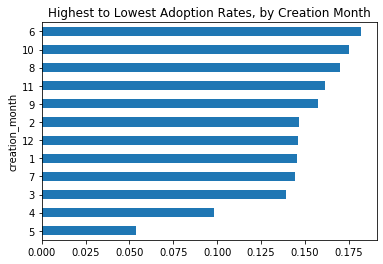

In [269]:
udf.groupby('creation_month').adopted.mean().sort_values().plot(kind='barh')
plt.title('Highest to Lowest Adoption Rates, by Creation Month');

... turned out to have an explanation.  In this case, the time period being analyzed ends with May, and the newer accounts have had less chance to be adopted.  Also the volume of new signups is increasing, so the May adoption rate is particularly low:

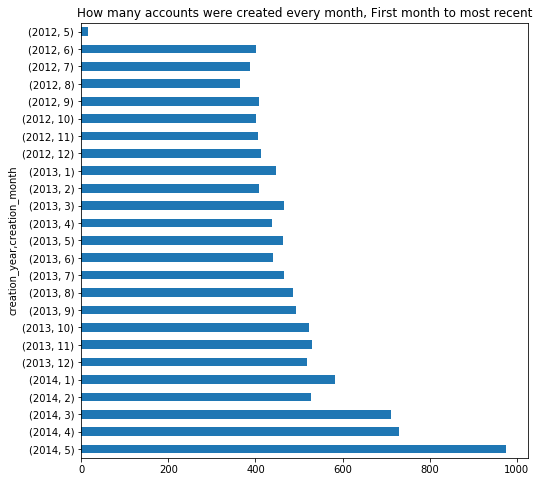

In [273]:
plt.figure(figsize=(8,8))
udf.groupby(['creation_year', 'creation_month']).adopted.size().sort_index().iloc[::-1].plot(kind='barh')
plt.title('How many accounts were created every month, First month to most recent');

The other time parts of the parsed creation dates (hours, weekdays, etc.) didn't produce any significant cyclicality.  

Having failed to find useful factors in the time dimension, I moved on to the ```creation_source```, which showed some predictive power;  ```SIGNUP_GOOGLE_AUTH``` and ```GUEST_INVITE``` sources were more likely than average to be adopted, whereas ```PERSONAL_PROJECT``` sources were much less likely than average:

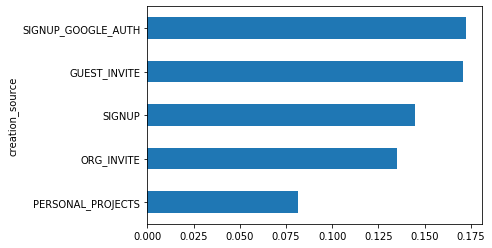

In [280]:
udf.groupby('creation_source').adopted.mean().sort_values().plot(kind='barh');

Examining the ```org_id``` feature, and grouping accounts into those orgs, there is a pretty normal distribution of adoption rates, without significant outliers, peaked around the mean rate of about 14% adoption.  Plotting the rates against the number of accounts for each org does show that as more and more accounts are added within any one organization, much past the mean number per org (about 29), they are less and less likely to be adopted.  The sweet spot for adopting seems to be adding numbers 10-25 within each org:

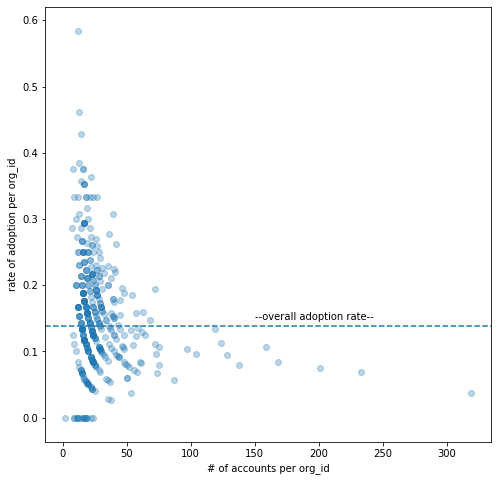

In [336]:
plt.figure(figsize=(8,8))
plt.scatter(sizes.values, rates.values, alpha=0.3)
plt.xlabel('# of accounts per org_id')
plt.ylabel('rate of adoption per org_id')
plt.axhline(udf.adopted.mean(), linestyle='--')
plt.text(150, udf.adopted.mean() + .01, '--overall adoption rate--');

The problem with the insight process above is that the number of accounts in each organization is a hindsight number, i.e. it doesn't have predictive power at the moment each user creates an account, because it isn't known yet.  All that's known is how many users in that org already have accounts created.  Furthermore, these totals come from a 2-year window, and we don't know how many user accounts there are in each org before this window.  Nevertheless, if you were shown 2 new accounts, and told that the first is with an organization that had 20 accounts created in the past 2 years, while the second had 200 accounts, you could maybe predict the first account is more likely to adopt.

Aside from knowing how many users there were already in the org when the new account was added, it might help the analysis further to have features describing each org, rather than just org_id's.

Beyond that, there wasn't much correlation between adoption rate and ```enabled_for_marketing_drip```, nor between adoption rate and ```opted_in_to_mailing_list```.  Accounts created via invites were slightly more likely to adopt than not by invite (0.028 correlation), and the negative correlation between number of users within an org and adoption, discussed above, is also included here (-0.084):

In [340]:
udf[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited', 'org_users', 'adopted']].corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,org_users,adopted
opted_in_to_mailing_list,1.000000,0.483529,0.006934,-0.014841,0.008838
enabled_for_marketing_drip,0.483529,1.000000,0.002216,-0.021556,0.006578
invited,0.006934,0.002216,1.000000,-0.002895,0.027831
org_users,-0.014841,-0.021556,-0.002895,1.000000,-0.083936
adopted,0.008838,0.006578,0.027831,-0.083936,1.000000


### ===== End of Report  ===========

## (Below here is just the code used for the report)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [69]:
udf = pd.read_csv('takehome_users.csv', encoding='latin') # StackO 18171739 (latin encoding works for some letters better than engine='python')
udf.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [70]:
udf['creation_time'] = pd.to_datetime(udf.creation_time)
udf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [71]:
print(min(udf.last_session_creation_time), max(udf.last_session_creation_time))

1338452406.0 1402066730.0


In [72]:
min(udf.creation_time)

Timestamp('2012-05-31 00:43:27')

In [73]:
udf['last_session_creation_time'] = pd.to_datetime(udf.last_session_creation_time, unit='s', origin='unix')
# This feature will not help here, since it won't be knowledge available when predicting future adoption

In [74]:
udf.head(12) # last line of this head has problematic characters if not encoded right. Not that it matters here.

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0


In [75]:
engaged = pd.read_csv('takehome_user_engagement.csv')
engaged.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [76]:
engaged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [77]:
engaged['time_stamp'] = pd.to_datetime(engaged.time_stamp)

Figure out which users are "adopted", meaning they engaged on 3 separate days within a 7 day period at some point.

In [87]:
# need a new column to indicate date only, since that's the determining factor in adoptedness
engaged['date'] = [t.date() for t in engaged.time_stamp]

In [88]:
# They look sorted already, but in case not....
engaged.sort_values('time_stamp', inplace=True)

In [112]:
from datetime import timedelta as td

adopted = set()
cutoff = td(days=7)
for u in engaged.user_id.unique():
    user_df = engaged[engaged.user_id == u]
    user_df.drop_duplicates(subset='date', inplace=True) # looking for 3 SEPARATE days here
    if len(user_df) > 2:  # don't waste time otherwise
        for i in range(len(user_df) - 2):
            if user_df.date.values[i] + cutoff >= user_df.date.values[i+2]:
                adopted.add(u)
                break
        

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [113]:
len(adopted)

1656

In [114]:
engaged.user_id.nunique()

8823

In [115]:
udf['adopted'] = udf.object_id.map(lambda u: u in adopted)

In [126]:
udf.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False


In [117]:
udf.adopted.sum()

1656

In [120]:
udf.org_id.nunique()

417

In [122]:
max(udf.org_id)

416

In [125]:
udf.shape

(12000, 11)

In [131]:
udf.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [141]:
udf['invited'] = udf.invited_by_user_id.notnull()
udf[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited', 'adopted']].corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,adopted
opted_in_to_mailing_list,1.000000,0.483529,0.006934,0.008838
enabled_for_marketing_drip,0.483529,1.000000,0.002216,0.006578
invited,0.006934,0.002216,1.000000,0.027831
adopted,0.008838,0.006578,0.027831,1.000000


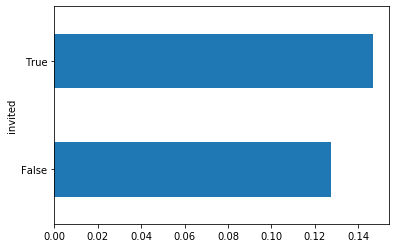

In [142]:
udf.groupby('invited').adopted.mean().plot(kind='barh')

In [235]:
udf['creation_month'] = [t.month for t in udf.creation_time]
udf['creation_day'] = [t.day for t in udf.creation_time]
udf['creation_weekday'] = [t.weekday() for t in udf.creation_time]
udf['creation_hour'] = [t.hour for t in udf.creation_time]
udf['creation_year'] = [t.year for t in udf.creation_time]

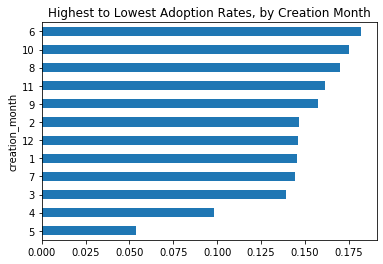

In [217]:
udf.groupby('creation_month').adopted.mean().sort_values().plot(kind='barh')
plt.title('Highest to Lowest Adoption Rates, by Creation Month');

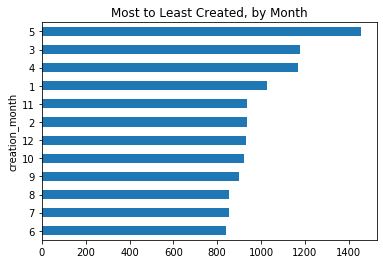

In [216]:
udf.groupby('creation_month').adopted.size().sort_values().plot(kind='barh')
plt.title('Most to Least Created, by Month');

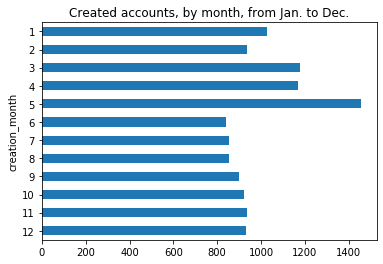

In [214]:
udf.groupby('creation_month').adopted.size().sort_index().iloc[::-1].plot(kind='barh')
plt.title('Created accounts, by month, from Jan. to Dec.');

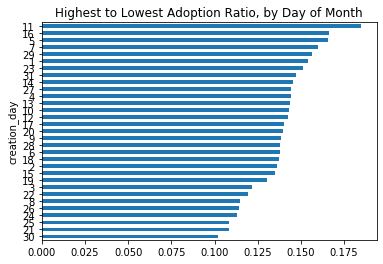

In [218]:
udf.groupby('creation_day').adopted.mean().sort_values().plot(kind='barh')
plt.title('Highest to Lowest Adoption Ratio, by Day of Month');

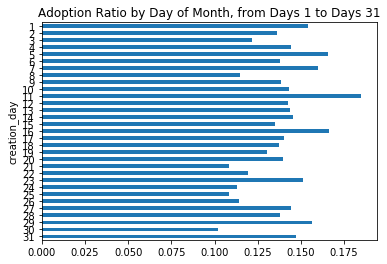

In [219]:
udf.groupby('creation_day').adopted.mean().sort_index().iloc[::-1].plot(kind='barh')
plt.title('Adoption Ratio by Day of Month, from Days 1 to Days 31');

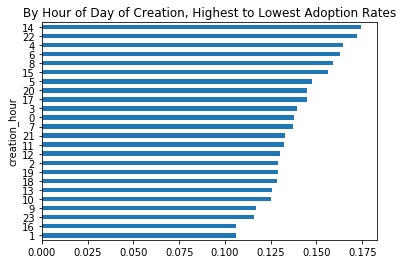

In [220]:
udf.groupby('creation_hour').adopted.mean().sort_values().plot(kind='barh')
plt.title('By Hour of Day of Creation, Highest to Lowest Adoption Rates');

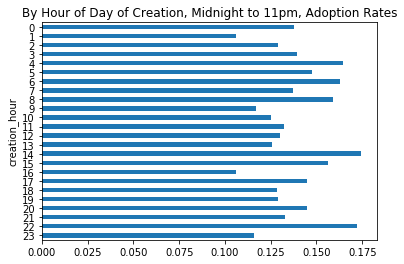

In [221]:
udf.groupby('creation_hour').adopted.mean().sort_index().iloc[::-1].plot(kind='barh')
plt.title('By Hour of Day of Creation, Midnight to 11pm, Adoption Rates');

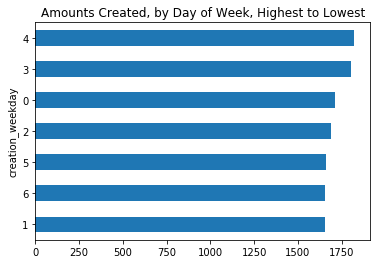

In [222]:
udf.groupby('creation_weekday').adopted.size().sort_values().plot(kind='barh')
plt.title('Amounts Created, by Day of Week, Highest to Lowest');

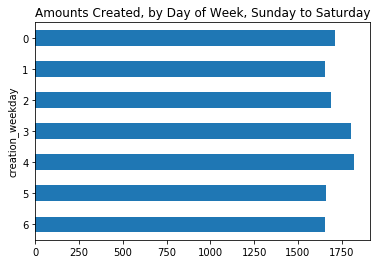

In [223]:
udf.groupby('creation_weekday').adopted.size().sort_index().iloc[::-1].plot(kind='barh')
plt.title('Amounts Created, by Day of Week, Sunday to Saturday');

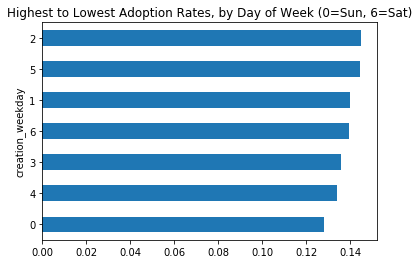

In [224]:
udf.groupby('creation_weekday').adopted.mean().sort_values().plot(kind='barh')
plt.title('Highest to Lowest Adoption Rates, by Day of Week (0=Sun, 6=Sat)');

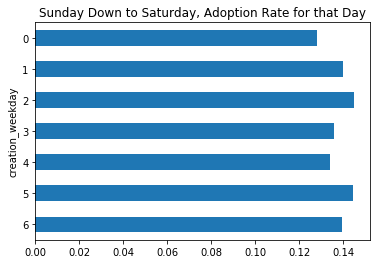

In [225]:
udf.groupby('creation_weekday').adopted.mean().sort_index().iloc[::-1].plot(kind='barh')
plt.title('Sunday Down to Saturday, Adoption Rate for that Day');

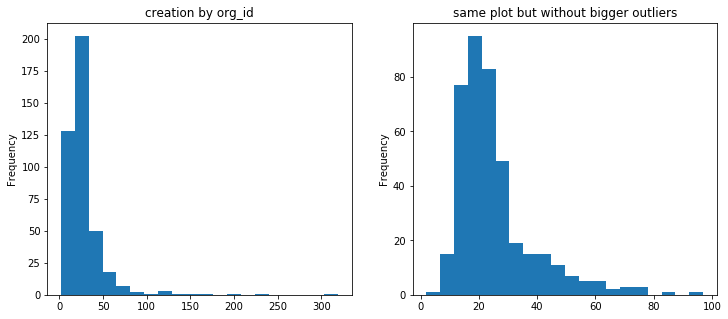

In [281]:
plt.figure(figsize=(12,5))
plt.subplot(121)
udf.groupby('org_id').size().plot(kind='hist', bins=20)
plt.title('creation by org_id')
plt.subplot(122)
sizes = udf.groupby('org_id').size()
sizes[sizes.values < 100].plot(kind='hist', bins=20)
plt.title('same plot but without bigger outliers');

In [286]:
sizes.values.mean()

28.776978417266186

In [259]:
sizes = udf.groupby('org_id').size()

org_id
0      319
1      233
2      201
3      168
4      159
      ... 
412     17
413     16
414     20
415     16
416      2
Length: 417, dtype: int64

In [267]:
rates = udf.groupby('org_id').adopted.mean()
rates

org_id
0      0.037618
1      0.068670
2      0.074627
3      0.083333
4      0.106918
         ...   
412    0.000000
413    0.187500
414    0.100000
415    0.375000
416    0.000000
Name: adopted, Length: 417, dtype: float64

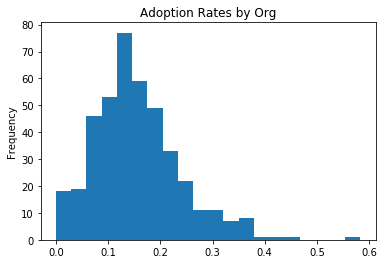

In [285]:
udf.groupby('org_id').adopted.mean().plot(kind='hist', bins=20)
plt.title('Adoption Rates by Org');

In [203]:
udf.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'invited', 'creation_month', 'creation_day', 'creation_weekday',
       'creation_hour'],
      dtype='object')

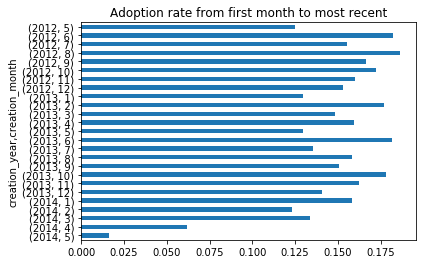

In [240]:
udf.groupby(['creation_year', 'creation_month']).adopted.mean().sort_index().iloc[::-1].plot(kind='barh')
plt.title('Adoption rate from first month to most recent');

In [287]:
udf['org_users'] = udf.org_id.map(sizes)

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


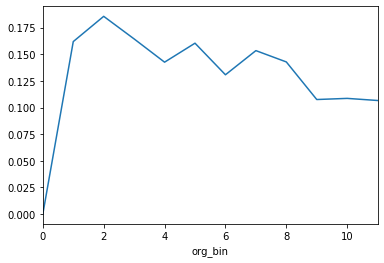

In [315]:
most_orgs = udf[udf.org_users <= 60]
most_orgs['org_bin'] = pd.cut(most_orgs.org_users, 12, labels=False)
most_orgs['org_rank_bin'] = pd.cut(most_orgs.org_rank, 12, labels=False)
most_orgs.groupby('org_bin').adopted.mean().plot();

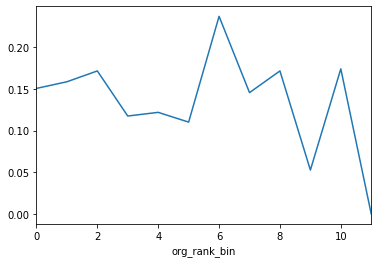

In [316]:
most_orgs.groupby('org_rank_bin').adopted.mean().plot();

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


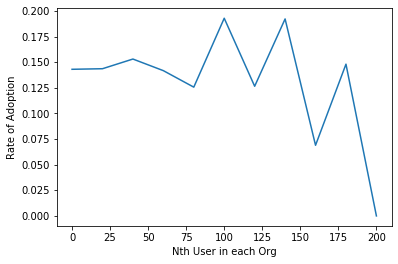

In [334]:
under200 = udf[udf.org_users < 200]
under200['org_rank_bin'] = pd.cut(under200.org_rank, 11, labels=False)
grouped = under200.groupby('org_rank_bin').adopted.mean()
plt.plot(grouped.index * 20, grouped.values)
plt.xlabel('Nth User in each Org')
plt.ylabel('Rate of Adoption');

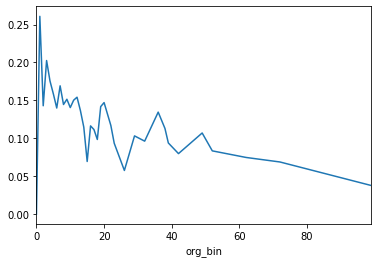

In [306]:
udf.groupby('org_bin').adopted.mean().plot();

In [311]:
# To show which order each user's account came in its org:
user_counter = [1] * 417 # org_id's are 0 thru 416
user_ranks = []
for user in udf.sort_values('creation_time').org_id.values:
    user_ranks.append(user_counter[user])
    user_counter[user] += 1
udf['org_rank'] = user_ranks